<a href="https://colab.research.google.com/github/integer-class/machine-learning/blob/main/Steven_Christian_Susanto/UTS_PegalBasedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pegal Based Learning:
MALIK ABDUL AZIS - 2241720240

MOCHAMAD WILDANI AZIZI - 2241720171

RENATHAN ANGGORO ARRY WIBISONO - 2241720239

STEVEN CHRISTIAN SUSANTO - 2241720003

# Dataset: FER2013


In [108]:
from google.colab import files
files.upload()

{}

In [52]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [53]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [54]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [55]:
import zipfile

with zipfile.ZipFile("fer2013.zip", "r") as zip_ref:
    zip_ref.extractall("fer2013")

# Check the dataset

In [56]:
import os

# List contents of the 'fer2013' directory
folder_path = '/content/fer2013'
print(os.listdir(folder_path))

['test', 'train']


# Step 1 Pre-Processing

In [80]:
import tensorflow as tf

# Path to the FER-2013 dataset directory
dataset_path = '/content/fer2013/train'

# Load the dataset as TensorFlow image dataset
batch_size = 32  # Adjust based on memory capacity
img_height, img_width = 48, 48  # Set image dimensions

# Load the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode="int",  # Use integer labels
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale",  # Since FER-2013 images are grayscale
    shuffle=True  # Shuffle the data
)

# Create an augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Randomly flip images
    tf.keras.layers.RandomRotation(0.1),  # Randomly rotate images
    tf.keras.layers.RandomZoom(0.1),  # Randomly zoom into images
    tf.keras.layers.RandomContrast(0.1)  # Randomly adjust contrast
])

# Apply augmentation to the dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Checking the output of augmented dataset
for images, labels in augmented_train_ds.take(1):
    print(f"Augmented Batch shape (images): {images.shape}")
    print(f"Augmented Batch shape (labels): {labels.shape}")


Found 28709 files belonging to 7 classes.
Augmented Batch shape (images): (32, 48, 48, 1)
Augmented Batch shape (labels): (32,)


# Step 2 Init

In [96]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
import numpy as np
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# FER-2013 has 7 classes
num_classes = 7

# the path to the train folder in the FER-2013 dataset
train_dir = dataset_path

import os

# List all subfolders inside the train directory
class_folders = os.listdir(train_dir)
print("Classes found in the train directory:", class_folders)
print("Number of classes:", len(class_folders))

# Image data preprocessing and augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values to [0, 1]
    rotation_range=20,  # Random rotations
    width_shift_range=0.2,  # Horizontal shifts
    height_shift_range=0.2,  # Vertical shifts
    shear_range=0.2,  # Shearing
    zoom_range=0.2,  # Zooming
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in missing pixels after transformation
    validation_split=0.2  # 20% of the data will be used for validation
)

# Set up the train generator from the `train_dir`
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # Resize all images to 48x48
    color_mode='grayscale',  # Use grayscale images
    batch_size=32,
    class_mode='categorical',  # Ensure this is 'categorical' for multi-class classification
    subset='training',  # This subset will be used for training
    shuffle=True  # Shuffle the dataset
)

# Set up the validation generator from the `train_dir`
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # Resize all images to 48x48
    color_mode='grayscale',  # Use grayscale images
    batch_size=32,
    class_mode='categorical',  # Ensure this is 'categorical' for multi-class classification
    subset='validation',  # This subset will be used for validation
    shuffle=True  # Shuffle the dataset
)

# Check the shape of the first batch of labels from the train generator
for X_batch, y_batch in train_generator:
    print("Shape of labels in the batch:", y_batch.shape)
    break  # Only check the first batch


# Define the model with the correct number of output classes
model = models.Sequential([
    layers.Input(shape=(48, 48, 1)),  # Input layer
    layers.Conv2D(32, (3, 3), activation='relu'),  # First convolutional layer
    layers.MaxPooling2D((2, 2)),  # First max pooling layer
    layers.Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
    layers.MaxPooling2D((2, 2)),  # Second max pooling layer
    layers.Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer
    layers.MaxPooling2D((2, 2)),  # Third max pooling layer
    layers.Flatten(),  # Flatten the output for the fully connected layers
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Initialize a list to store labels
labels = []

# Calculate class weights
# Extract labels from train_ds to calculate class weights without exhausting the dataset
labels = []

for _, y in train_ds.unbatch():
    # Ensure each label is appended as a one-dimensional array
    labels.append(np.argmax(y.numpy(), axis=-1))

# Convert labels list to a numpy array
labels = np.array(labels)

# Check if the labels array is not empty before computing class weights
if labels.size > 0:
    # Compute class weights
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
else:
    class_weights_dict = {}

print("Class weights:", class_weights_dict)

Classes found in the train directory: ['sad', 'disgust', 'surprise', 'angry', 'fear', 'happy', 'neutral']
Number of classes: 7
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Shape of labels in the batch: (32, 7)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)                   │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: 1.0}


# Step 3 Training

Epoch 1/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.4227 - loss: 1.4787 - val_accuracy: 0.4424 - val_loss: 1.4605
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4375 - loss: 1.4592 - val_accuracy: 0.6923 - val_loss: 0.8971
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.4462 - loss: 1.4359 - val_accuracy: 0.4450 - val_loss: 1.4353
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - accuracy: 0.4688 - loss: 1.3154 - val_accuracy: 0.4615 - val_loss: 1.4454
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.4590 - loss: 1.4094 - val_accuracy: 0.4476 - val_loss: 1.4286
Epoch 6/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5625 - loss: 1.2113 - val_accuracy: 0.2308 - val_loss: 1.7705
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.4618 - loss: 1.3869 - val_accuracy: 0.4689 - val_loss: 1.3899
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 24us/step - accuracy: 0.4062 - loss: 1.5114 - val_a

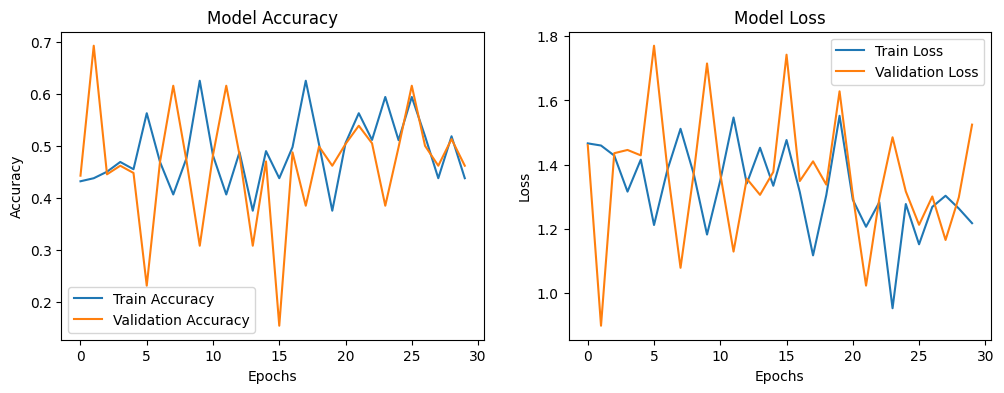

In [100]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,  # Stop after 5 epochs without improvement
                               restore_best_weights=True)

# Set training parameters
epochs = 30
batch_size = 32

# Train the model using the full dataset for both training and validation
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,  # Use validation data from validation_generator
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weights_dict  # Use computed class weights
)

# Optionally: Plotting training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plotting the accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


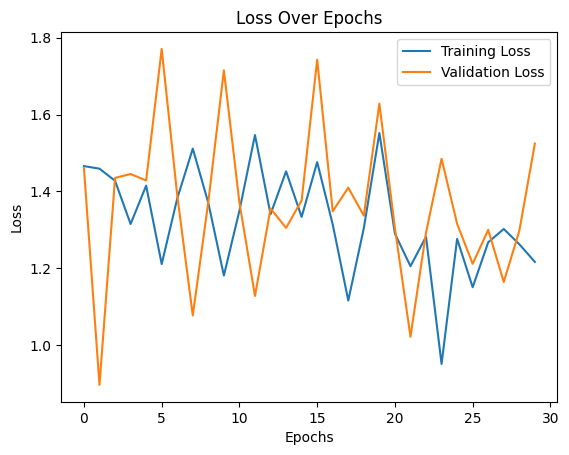

In [101]:
import matplotlib.pyplot as plt

# Assuming `history` contains the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Step 4 Eval

In [102]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = 'fer2013/train'  # Path to training data
test_dir = 'fer2013/test'    # Path to testing data

# Load the training dataset
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',  # Use grayscale images for FER-2013
)

# Load the test dataset
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
)

# Check the class names
print("Class Names:", train_ds.class_names)


Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Class Names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Shape of test_labels: (32,)


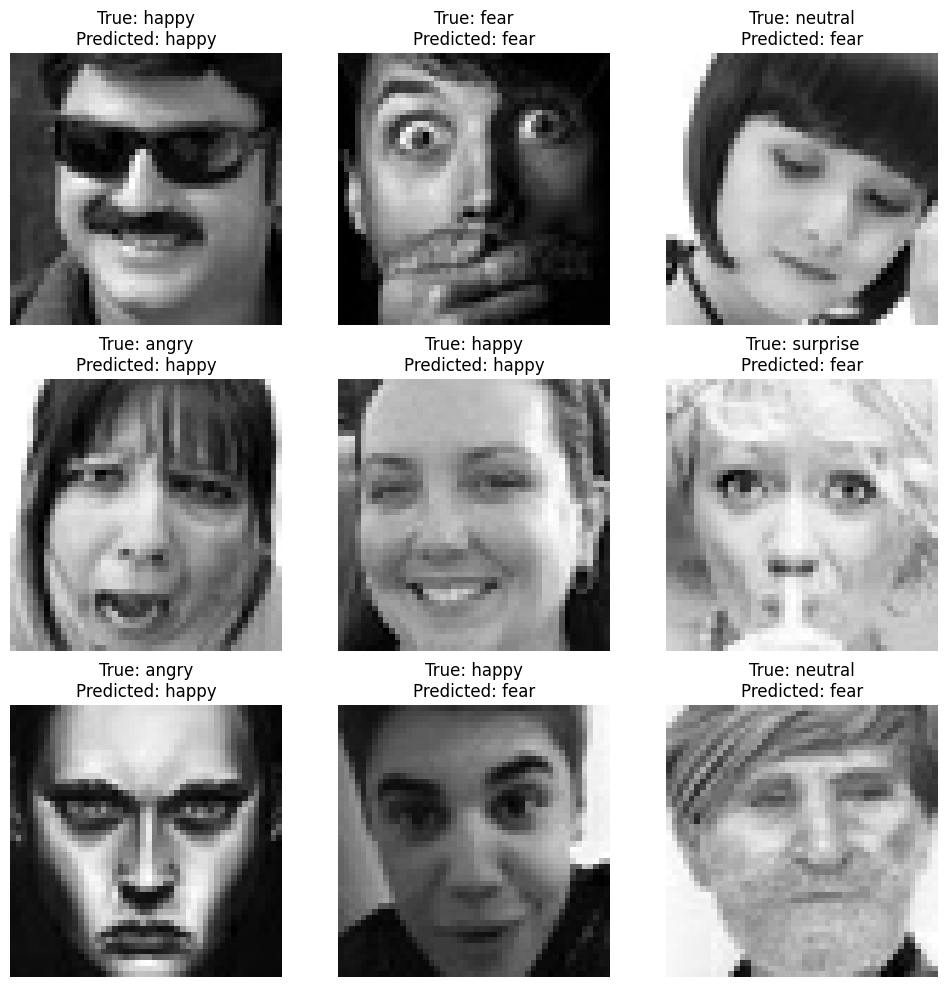

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of test data
test_images, test_labels = next(iter(test_ds))  # Get a batch

# Make predictions
predictions = model.predict(test_images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Check the shape of test_labels
print("Shape of test_labels:", test_labels.shape)

# If test_labels is one-dimensional (for binary class), just use it directly
if len(test_labels.shape) == 1:
    true_classes = test_labels.numpy()  # No need for argmax
else:
    true_classes = np.argmax(test_labels.numpy(), axis=1)

# Visualize some predictions
plt.figure(figsize=(12, 12))
for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy().squeeze(), cmap='gray')  # Show the image
    plt.title(f'True: {train_ds.class_names[true_classes[i]]}\nPredicted: {train_ds.class_names[predicted_classes[i]]}')
    plt.axis('off')

plt.show()
